In [138]:
import pandas as pd
import pymysql
from sqlalchemy import create_engine
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import os
import pickle
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import Normalizer, OneHotEncoder
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings('ignore')

pd.options.display.max_columns = None

import getpass  # to get the password without showing the input
password = getpass.getpass()

connection_string = 'mysql+pymysql://root:' + password + '@localhost/bank'
engine = create_engine(connection_string)

········


In [6]:
query = '''SELECT * from credit_card_classification.credit_card_data;'''

df = pd.read_sql_query(query, engine)
df

,ï»¿Customer Number,Offer Accepted,Reward,Mailer Type,Income Level,# Bank Accounts Open,Overdraft Protection,Credit Rating,# Credit Cards Held,# Homes Owned,Household Size,Own Your Home,Average Balance,Q1 Balance,Q2 Balance,Q3 Balance
0,1,No,Air Miles,Letter,High,1,No,High,2,1,4,No,1160.75,1669,877,1095
1,2,No,Air Miles,Letter,Medium,1,No,Medium,2,2,5,Yes,147.25,39,106,78
2,3,No,Air Miles,Postcard,High,2,No,Medium,2,1,2,Yes,276.50,367,352,145
3,4,No,Air Miles,Letter,Medium,2,No,High,1,1,4,No,1219.00,1578,1760,1119
4,5,No,Air Miles,Letter,Medium,1,No,Medium,2,1,6,Yes,1211.00,2140,1357,982
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17971,17996,No,Cash Back,Letter,High,1,No,Low,1,1,5,Yes,167.50,136,65,71
17972,17997,No,Cash Back,Letter,High,1,No,Low,3,1,3,Yes,850.50,984,940,943
17973,17998,No,Cash Back,Letter,High,1,No,Low,2,1,4,No,1087.25,918,767,1170
17974,17999,No,Cash Back,Letter,Medium,1,No,Medium,4,2,2,Yes,1022.25,626,983,865


In [7]:
#let's first standardize columns
df.columns = [column.lower().replace(' ', '_') for column in df.columns]
df.columns

Index(['ï»¿customer_number', 'offer_accepted', 'reward', 'mailer_type',
       'income_level', '#_bank_accounts_open', 'overdraft_protection',
       'credit_rating', '#_credit_cards_held', '#_homes_owned',
       'household_size', 'own_your_home', 'average_balance', 'q1_balance',
       'q2_balance', 'q3_balance'],
      dtype='object')

In [13]:
#now let's define a function to remove special characters from column names (except "_")
#def alphanum(x, columns=[]):
 #   alpha=['a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','p','q','r','s','t','u','v','w','x','y','z']
  #  numeric= ['0','1','2','3','4','5','6','7','8','9']
   # keep=['_']
    #for col in columns:
     #   for arg in col:
     #       if arg in{alpha,numeric,keep}:
     #           pass
      #      else:
       #         arg.replace(arg, "")
   # return columns
    
                

In [14]:
#for col in df.columns:
 #   df[col] = df[col].apply(clean_char(df, columns=['ï»¿customer_number', 'offer_accepted', 'reward', 'mailer_type',
  #     'income_level', '#_bank_accounts_open', 'overdraft_protection',
   #    'credit_rating', '#_credit_cards_held', '#_homes_owned',
    #   'household_size', 'own_your_home', 'average_balance', 'q1_balance',
     #  'q2_balance', 'q3_balance', 'q4_balance']))

In [16]:
#standardizing columns
df.columns = [column.lower().replace('ï»¿', '') for column in df.columns]
df.columns = [column.lower().replace('#_', '') for column in df.columns]
df.columns

Index(['customer_number', 'offer_accepted', 'reward', 'mailer_type',
       'income_level', 'bank_accounts_open', 'overdraft_protection',
       'credit_rating', 'credit_cards_held', 'homes_owned', 'household_size',
       'own_your_home', 'average_balance', 'q1_balance', 'q2_balance',
       'q3_balance'],
      dtype='object')

In [34]:
df.describe()

,customer_number,bank_accounts_open,credit_cards_held,homes_owned,household_size,average_balance,q1_balance,q2_balance,q3_balance
count,17976.000000,17976.000000,17976.000000,17976.000000,17976.000000,17976.000000,17976.000000,17976.000000,17976.000000
mean,8999.727192,1.255730,1.903427,1.203549,3.499110,940.515562,910.450656,999.392190,1042.033600
std,5196.958865,0.472405,0.797086,0.427446,1.114476,350.297837,620.077060,457.402268,553.452599
min,1.000000,1.000000,1.000000,1.000000,1.000000,48.250000,0.000000,0.000000,0.000000
25%,4498.750000,1.000000,1.000000,1.000000,3.000000,787.500000,392.750000,663.000000,633.000000
50%,9000.500000,1.000000,2.000000,1.000000,3.000000,1007.000000,772.000000,1032.000000,945.500000
75%,13501.250000,1.000000,2.000000,1.000000,4.000000,1153.250000,1521.000000,1342.000000,1463.000000
max,18000.000000,3.000000,4.000000,3.000000,9.000000,3366.250000,3450.000000,3421.000000,3823.000000


In [35]:
df.isna().sum()

customer_number         0
offer_accepted          0
reward                  0
mailer_type             0
income_level            0
bank_accounts_open      0
overdraft_protection    0
credit_rating           0
credit_cards_held       0
homes_owned             0
household_size          0
own_your_home           0
average_balance         0
q1_balance              0
q2_balance              0
q3_balance              0
dtype: int64

In [19]:
df.info(verbose=True, null_counts=True) #no null values to deal with

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17976 entries, 0 to 17975
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   customer_number       17976 non-null  int64  
 1   offer_accepted        17976 non-null  object 
 2   reward                17976 non-null  object 
 3   mailer_type           17976 non-null  object 
 4   income_level          17976 non-null  object 
 5   bank_accounts_open    17976 non-null  int64  
 6   overdraft_protection  17976 non-null  object 
 7   credit_rating         17976 non-null  object 
 8   credit_cards_held     17976 non-null  int64  
 9   homes_owned           17976 non-null  int64  
 10  household_size        17976 non-null  int64  
 11  own_your_home         17976 non-null  object 
 12  average_balance       17976 non-null  float64
 13  q1_balance            17976 non-null  int64  
 14  q2_balance            17976 non-null  int64  
 15  q3_balance         

In [29]:
cat = df.select_dtypes('object')
cat

,offer_accepted,reward,mailer_type,income_level,overdraft_protection,credit_rating,own_your_home
0,No,Air Miles,Letter,High,No,High,No
1,No,Air Miles,Letter,Medium,No,Medium,Yes
2,No,Air Miles,Postcard,High,No,Medium,Yes
3,No,Air Miles,Letter,Medium,No,High,No
4,No,Air Miles,Letter,Medium,No,Medium,Yes
...,...,...,...,...,...,...,...
17971,No,Cash Back,Letter,High,No,Low,Yes
17972,No,Cash Back,Letter,High,No,Low,Yes
17973,No,Cash Back,Letter,High,No,Low,No
17974,No,Cash Back,Letter,Medium,No,Medium,Yes


In [37]:
for col in df.select_dtypes('object'):
    print(df[col].value_counts(), '\n') #no reattribution to operate on uniques

No     16955
Yes     1021
Name: offer_accepted, dtype: int64 

Air Miles    6047
Cash Back    5995
Points       5934
Name: reward, dtype: int64 

Postcard    9134
Letter      8842
Name: mailer_type, dtype: int64 

Medium    9002
High      4519
Low       4455
Name: income_level, dtype: int64 

No     15300
Yes     2676
Name: overdraft_protection, dtype: int64 

High      6064
Medium    5964
Low       5948
Name: credit_rating, dtype: int64 

Yes    11636
No      6340
Name: own_your_home, dtype: int64 



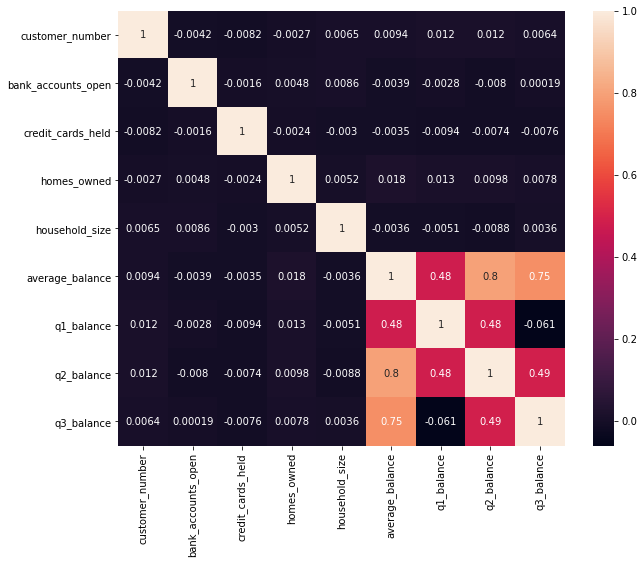

In [38]:
corr_matrix=df.corr(method='pearson')
fig, ax = plt.subplots(figsize=(10, 8))
ax = sns.heatmap(corr_matrix, annot=True)
plt.show()

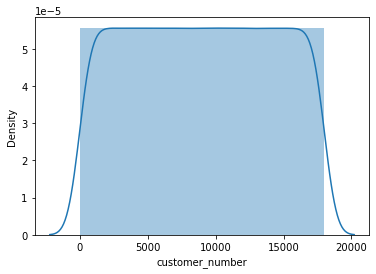

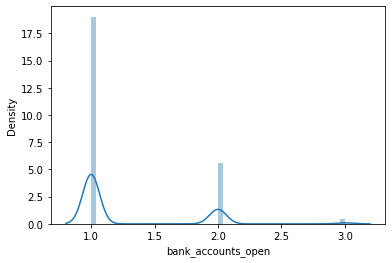

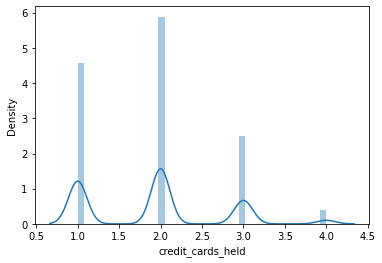

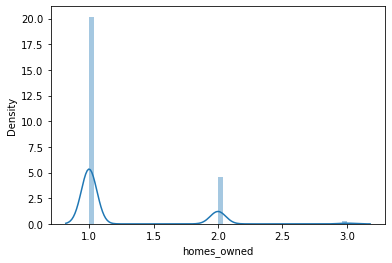

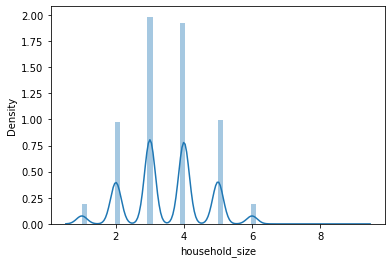

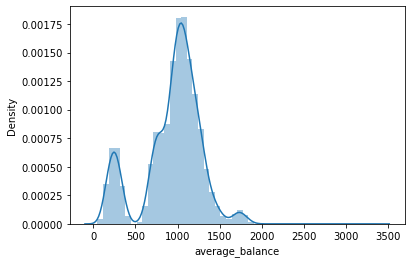

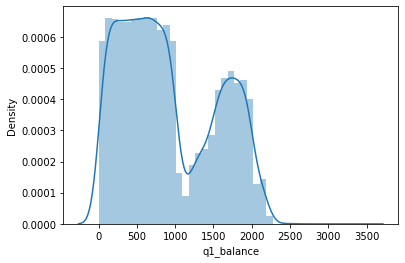

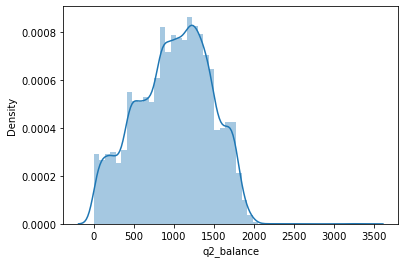

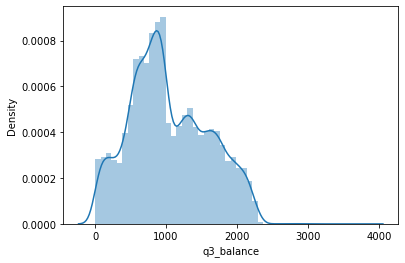

In [39]:
for col in df.select_dtypes(np.number):
    sns.distplot(df[col])
    plt.show()

In [40]:
# customer_number is the id, unique, so I passed it as the index
df = df.set_index('customer_number')
df.head()

,offer_accepted,reward,mailer_type,income_level,bank_accounts_open,overdraft_protection,credit_rating,credit_cards_held,homes_owned,household_size,own_your_home,average_balance,q1_balance,q2_balance,q3_balance
customer_number,,,,,,,,,,,,,,,
1,No,Air Miles,Letter,High,1,No,High,2,1,4,No,1160.75,1669,877,1095
2,No,Air Miles,Letter,Medium,1,No,Medium,2,2,5,Yes,147.25,39,106,78
3,No,Air Miles,Postcard,High,2,No,Medium,2,1,2,Yes,276.50,367,352,145
4,No,Air Miles,Letter,Medium,2,No,High,1,1,4,No,1219.00,1578,1760,1119
5,No,Air Miles,Letter,Medium,1,No,Medium,2,1,6,Yes,1211.00,2140,1357,982


In [93]:
y = df['offer_accepted']
X = df.drop('offer_accepted', axis=1)

In [94]:
X

,reward,mailer_type,income_level,bank_accounts_open,overdraft_protection,credit_rating,credit_cards_held,homes_owned,household_size,own_your_home,average_balance,q1_balance,q2_balance,q3_balance
customer_number,,,,,,,,,,,,,,
1,Air Miles,Letter,High,1,No,High,2,1,4,No,1160.75,1669,877,1095
2,Air Miles,Letter,Medium,1,No,Medium,2,2,5,Yes,147.25,39,106,78
3,Air Miles,Postcard,High,2,No,Medium,2,1,2,Yes,276.50,367,352,145
4,Air Miles,Letter,Medium,2,No,High,1,1,4,No,1219.00,1578,1760,1119
5,Air Miles,Letter,Medium,1,No,Medium,2,1,6,Yes,1211.00,2140,1357,982
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17996,Cash Back,Letter,High,1,No,Low,1,1,5,Yes,167.50,136,65,71
17997,Cash Back,Letter,High,1,No,Low,3,1,3,Yes,850.50,984,940,943
17998,Cash Back,Letter,High,1,No,Low,2,1,4,No,1087.25,918,767,1170


In [95]:
#encoding categorical variables
X = pd.get_dummies(X, columns=['reward', 'mailer_type', 'income_level', 'overdraft_protection', 'credit_rating', 'own_your_home'])
X

,bank_accounts_open,credit_cards_held,homes_owned,household_size,average_balance,q1_balance,q2_balance,q3_balance,reward_Air Miles,reward_Cash Back,reward_Points,mailer_type_Letter,mailer_type_Postcard,income_level_High,income_level_Low,income_level_Medium,overdraft_protection_No,overdraft_protection_Yes,credit_rating_High,credit_rating_Low,credit_rating_Medium,own_your_home_No,own_your_home_Yes
customer_number,,,,,,,,,,,,,,,,,,,,,,,
1,1,2,1,4,1160.75,1669,877,1095,1,0,0,1,0,1,0,0,1,0,1,0,0,1,0
2,1,2,2,5,147.25,39,106,78,1,0,0,1,0,0,0,1,1,0,0,0,1,0,1
3,2,2,1,2,276.50,367,352,145,1,0,0,0,1,1,0,0,1,0,0,0,1,0,1
4,2,1,1,4,1219.00,1578,1760,1119,1,0,0,1,0,0,0,1,1,0,1,0,0,1,0
5,1,2,1,6,1211.00,2140,1357,982,1,0,0,1,0,0,0,1,1,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17996,1,1,1,5,167.50,136,65,71,0,1,0,1,0,1,0,0,1,0,0,1,0,0,1
17997,1,3,1,3,850.50,984,940,943,0,1,0,1,0,1,0,0,1,0,0,1,0,0,1
17998,1,2,1,4,1087.25,918,767,1170,0,1,0,1,0,1,0,0,1,0,0,1,0,1,0


In [96]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [97]:
classification = LogisticRegression(random_state=42, max_iter=10000)
classification.fit(X_train, y_train)

LogisticRegression(max_iter=10000, random_state=42)

In [98]:
classification.score(X_test, y_test) #without dealing with data imbalance, accuracy is 94.68%

0.9468854282536151

In [99]:
df['offer_accepted'].value_counts() #data imbalance

No     16955
Yes     1021
Name: offer_accepted, dtype: int64

In [100]:
#I decide to upsample Yes and downsample No --> sample = 8 000
No8 = df[df['offer_accepted'] == 'No'].sample(8000, replace=True)
Yes8 = df[df['offer_accepted'] == 'Yes'].sample(8000, replace=True)
sampled8 = pd.concat([Yes, No]).sample(frac=1)
sampled8

,offer_accepted,reward,mailer_type,income_level,bank_accounts_open,overdraft_protection,credit_rating,credit_cards_held,homes_owned,household_size,own_your_home,average_balance,q1_balance,q2_balance,q3_balance
customer_number,,,,,,,,,,,,,,,
5313,No,Cash Back,Postcard,Medium,2,No,High,3,1,4,Yes,180.75,94,201,9
503,Yes,Points,Postcard,Low,1,No,Low,2,1,1,No,1215.75,391,1598,2023
4164,No,Points,Postcard,Medium,1,No,High,2,1,3,Yes,743.75,694,845,873
1970,Yes,Cash Back,Postcard,Medium,1,No,Low,2,1,3,Yes,710.25,583,663,969
17918,No,Cash Back,Postcard,Medium,1,No,High,2,1,2,No,973.50,69,1591,1213
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2831,No,Cash Back,Postcard,Medium,1,No,Medium,1,1,5,Yes,1456.00,936,1505,2070
6535,Yes,Cash Back,Postcard,Medium,2,No,Low,2,2,5,No,209.00,246,139,265
15618,Yes,Air Miles,Postcard,Low,1,Yes,High,2,1,5,Yes,215.25,462,74,84


In [101]:
sampled8.offer_accepted.value_counts()
#checking if sampling was correcly done

No     8000
Yes    8000
Name: offer_accepted, dtype: int64

In [105]:
Xs8 = sampled8.drop('offer_accepted', axis=1)
ys8 = sampled8['offer_accepted']

In [106]:
Xs8 = pd.get_dummies(Xs8)
Xs8

,bank_accounts_open,credit_cards_held,homes_owned,household_size,average_balance,q1_balance,q2_balance,q3_balance,reward_Air Miles,reward_Cash Back,reward_Points,mailer_type_Letter,mailer_type_Postcard,income_level_High,income_level_Low,income_level_Medium,overdraft_protection_No,overdraft_protection_Yes,credit_rating_High,credit_rating_Low,credit_rating_Medium,own_your_home_No,own_your_home_Yes
customer_number,,,,,,,,,,,,,,,,,,,,,,,
5313,2,3,1,4,180.75,94,201,9,0,1,0,0,1,0,0,1,1,0,1,0,0,0,1
503,1,2,1,1,1215.75,391,1598,2023,0,0,1,0,1,0,1,0,1,0,0,1,0,1,0
4164,1,2,1,3,743.75,694,845,873,0,0,1,0,1,0,0,1,1,0,1,0,0,0,1
1970,1,2,1,3,710.25,583,663,969,0,1,0,0,1,0,0,1,1,0,0,1,0,0,1
17918,1,2,1,2,973.50,69,1591,1213,0,1,0,0,1,0,0,1,1,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2831,1,1,1,5,1456.00,936,1505,2070,0,1,0,0,1,0,0,1,1,0,0,0,1,0,1
6535,2,2,2,5,209.00,246,139,265,0,1,0,0,1,0,0,1,1,0,0,1,0,1,0
15618,1,2,1,5,215.25,462,74,84,1,0,0,0,1,0,1,0,0,1,1,0,0,0,1


In [107]:
Xs8_train, Xs8_test, ys8_train, ys8_test = train_test_split(Xs8, ys8, test_size=0.2, random_state=42)

In [108]:
classification8 = LogisticRegression(random_state=42, max_iter=10000)
classification8.fit(Xs8_train, ys8_train)

LogisticRegression(max_iter=10000, random_state=42)

In [109]:
classification8.score(Xs8_test, ys8_test) #accuracy after balancing data is 67.3% --> why ?

0.6821875

In [110]:
#I decide to upsample Yes and downsample No --> sample = 4 000
No4 = df[df['offer_accepted'] == 'No'].sample(4000, replace=True)
Yes4 = df[df['offer_accepted'] == 'Yes'].sample(4000, replace=True)
sampled4 = pd.concat([Yes4, No4]).sample(frac=1)
sampled4

,offer_accepted,reward,mailer_type,income_level,bank_accounts_open,overdraft_protection,credit_rating,credit_cards_held,homes_owned,household_size,own_your_home,average_balance,q1_balance,q2_balance,q3_balance
customer_number,,,,,,,,,,,,,,,
9153,No,Cash Back,Postcard,High,1,No,High,2,1,4,No,1333.25,1871,1486,1124
10800,Yes,Cash Back,Letter,Medium,1,No,Low,1,1,5,No,1141.00,367,908,2132
9721,Yes,Air Miles,Letter,Low,1,No,Medium,2,1,3,Yes,652.50,745,586,596
12161,No,Air Miles,Postcard,High,1,No,High,2,2,5,Yes,1061.50,169,918,1750
9963,No,Points,Letter,Medium,1,Yes,Medium,2,2,5,No,781.50,714,901,983
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7708,Yes,Cash Back,Postcard,Medium,2,No,Low,1,2,3,No,1288.25,1462,441,1836
17307,No,Points,Letter,Medium,1,No,Low,3,1,4,Yes,1168.00,80,1259,1250
14683,Yes,Air Miles,Postcard,Medium,2,Yes,Low,1,1,3,Yes,238.00,228,113,456


In [111]:
Xs4 = sampled4.drop('offer_accepted', axis=1)
ys4 = sampled4['offer_accepted']

In [112]:
Xs4 = pd.get_dummies(Xs4)
Xs4

,bank_accounts_open,credit_cards_held,homes_owned,household_size,average_balance,q1_balance,q2_balance,q3_balance,reward_Air Miles,reward_Cash Back,reward_Points,mailer_type_Letter,mailer_type_Postcard,income_level_High,income_level_Low,income_level_Medium,overdraft_protection_No,overdraft_protection_Yes,credit_rating_High,credit_rating_Low,credit_rating_Medium,own_your_home_No,own_your_home_Yes
customer_number,,,,,,,,,,,,,,,,,,,,,,,
9153,1,2,1,4,1333.25,1871,1486,1124,0,1,0,0,1,1,0,0,1,0,1,0,0,1,0
10800,1,1,1,5,1141.00,367,908,2132,0,1,0,1,0,0,0,1,1,0,0,1,0,1,0
9721,1,2,1,3,652.50,745,586,596,1,0,0,1,0,0,1,0,1,0,0,0,1,0,1
12161,1,2,2,5,1061.50,169,918,1750,1,0,0,0,1,1,0,0,1,0,1,0,0,0,1
9963,1,2,2,5,781.50,714,901,983,0,0,1,1,0,0,0,1,0,1,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7708,2,1,2,3,1288.25,1462,441,1836,0,1,0,0,1,0,0,1,1,0,0,1,0,1,0
17307,1,3,1,4,1168.00,80,1259,1250,0,0,1,1,0,0,0,1,1,0,0,1,0,0,1
14683,2,1,1,3,238.00,228,113,456,1,0,0,0,1,0,0,1,0,1,0,1,0,0,1


In [113]:
Xs4_train, Xs4_test, ys4_train, ys4_test = train_test_split(Xs4, ys4, test_size=0.2, random_state=42)

In [114]:
classification4 = LogisticRegression(random_state=42, max_iter=10000)
classification4.fit(Xs4_train, ys4_train)

LogisticRegression(max_iter=10000, random_state=42)

In [115]:
classification4.score(Xs4_test, ys4_test) #accuracy after balancing data is 68.2% --> why ?

0.69125

In [116]:
#I decide to downsample Yes --> sample = 1 021 #count of yes
No1 = df[df['offer_accepted'] == 'No'].sample(1021, replace=True)
Yes1 = df[df['offer_accepted'] == 'Yes']
sampled1 = pd.concat([Yes1, No1]).sample(frac=1)
sampled1

,offer_accepted,reward,mailer_type,income_level,bank_accounts_open,overdraft_protection,credit_rating,credit_cards_held,homes_owned,household_size,own_your_home,average_balance,q1_balance,q2_balance,q3_balance
customer_number,,,,,,,,,,,,,,,
7655,No,Cash Back,Letter,High,2,No,Medium,1,1,5,No,691.50,747,701,756
478,Yes,Air Miles,Postcard,Medium,2,No,High,2,1,3,Yes,1054.75,1364,1360,446
6214,Yes,Points,Letter,High,1,Yes,Low,1,1,3,Yes,1001.50,361,804,2058
14271,No,Cash Back,Postcard,Low,1,No,Low,2,2,6,Yes,796.75,731,596,912
14580,Yes,Air Miles,Postcard,Medium,2,No,Low,3,2,4,Yes,924.50,131,977,1979
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13042,No,Cash Back,Postcard,Medium,1,No,High,3,1,3,Yes,952.75,1451,1704,595
17220,Yes,Air Miles,Postcard,Low,1,No,Low,3,1,2,Yes,1026.75,1993,1158,681
10449,No,Cash Back,Letter,Medium,2,No,Low,1,1,5,No,728.00,109,646,1536


In [117]:
Xs1 = sampled1.drop('offer_accepted', axis=1)
ys1 = sampled1['offer_accepted']

In [118]:
Xs1 = pd.get_dummies(Xs1)
Xs1

,bank_accounts_open,credit_cards_held,homes_owned,household_size,average_balance,q1_balance,q2_balance,q3_balance,reward_Air Miles,reward_Cash Back,reward_Points,mailer_type_Letter,mailer_type_Postcard,income_level_High,income_level_Low,income_level_Medium,overdraft_protection_No,overdraft_protection_Yes,credit_rating_High,credit_rating_Low,credit_rating_Medium,own_your_home_No,own_your_home_Yes
customer_number,,,,,,,,,,,,,,,,,,,,,,,
7655,2,1,1,5,691.50,747,701,756,0,1,0,1,0,1,0,0,1,0,0,0,1,1,0
478,2,2,1,3,1054.75,1364,1360,446,1,0,0,0,1,0,0,1,1,0,1,0,0,0,1
6214,1,1,1,3,1001.50,361,804,2058,0,0,1,1,0,1,0,0,0,1,0,1,0,0,1
14271,1,2,2,6,796.75,731,596,912,0,1,0,0,1,0,1,0,1,0,0,1,0,0,1
14580,2,3,2,4,924.50,131,977,1979,1,0,0,0,1,0,0,1,1,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13042,1,3,1,3,952.75,1451,1704,595,0,1,0,0,1,0,0,1,1,0,1,0,0,0,1
17220,1,3,1,2,1026.75,1993,1158,681,1,0,0,0,1,0,1,0,1,0,0,1,0,0,1
10449,2,1,1,5,728.00,109,646,1536,0,1,0,1,0,0,0,1,1,0,0,1,0,1,0


In [119]:
Xs1_train, Xs1_test, ys1_train, ys1_test = train_test_split(Xs1, ys1, test_size=0.2, random_state=42)

In [120]:
classification1 = LogisticRegression(random_state=42, max_iter=10000)
classification1.fit(Xs1_train, ys1_train)

LogisticRegression(max_iter=10000, random_state=42)

In [121]:
classification1.score(Xs1_test, ys1_test) #accuracy after balancing data is 66.5% --> why ?

0.706601466992665

In [128]:
#now, let's try another sampling method to improve our model #SMOTE
smote = SMOTE()

XSM = df.drop('offer_accepted', axis=1)
ySM = df['offer_accepted']

In [129]:
#first, let's encode categoricals
Xsmote = pd.get_dummies(XSM)
Xsmote

,bank_accounts_open,credit_cards_held,homes_owned,household_size,average_balance,q1_balance,q2_balance,q3_balance,reward_Air Miles,reward_Cash Back,reward_Points,mailer_type_Letter,mailer_type_Postcard,income_level_High,income_level_Low,income_level_Medium,overdraft_protection_No,overdraft_protection_Yes,credit_rating_High,credit_rating_Low,credit_rating_Medium,own_your_home_No,own_your_home_Yes
customer_number,,,,,,,,,,,,,,,,,,,,,,,
1,1,2,1,4,1160.75,1669,877,1095,1,0,0,1,0,1,0,0,1,0,1,0,0,1,0
2,1,2,2,5,147.25,39,106,78,1,0,0,1,0,0,0,1,1,0,0,0,1,0,1
3,2,2,1,2,276.50,367,352,145,1,0,0,0,1,1,0,0,1,0,0,0,1,0,1
4,2,1,1,4,1219.00,1578,1760,1119,1,0,0,1,0,0,0,1,1,0,1,0,0,1,0
5,1,2,1,6,1211.00,2140,1357,982,1,0,0,1,0,0,0,1,1,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17996,1,1,1,5,167.50,136,65,71,0,1,0,1,0,1,0,0,1,0,0,1,0,0,1
17997,1,3,1,3,850.50,984,940,943,0,1,0,1,0,1,0,0,1,0,0,1,0,0,1
17998,1,2,1,4,1087.25,918,767,1170,0,1,0,1,0,1,0,0,1,0,0,1,0,1,0


In [130]:
X_sm, y_sm = smote.fit_resample(Xsmote, ySM)
y_sm.value_counts()

No     16955
Yes    16955
Name: offer_accepted, dtype: int64

In [131]:
Xsmote_train, Xsmote_test, ySM_train, ySM_test = train_test_split(Xsmote, ySM, test_size=0.2, random_state=42)

In [132]:
classificationSMOTE = LogisticRegression(random_state=42, max_iter=10000)
classificationSMOTE.fit(Xsmote_train, ySM_train)

LogisticRegression(max_iter=10000, random_state=42)

In [133]:
classificationSMOTE.score(Xsmote_test, ySM_test)

0.9468854282536151

In [122]:
#summary of classification scores with sampling method
classification1.score(Xs1_test, ys1_test) #downsampled to count(Yes) --> 1021

0.706601466992665

In [123]:
classificationS.score(Xs_test, ys_test) #sampled to 8k


0.6734375

In [124]:
classification4.score(Xs4_test, ys4_test) #sampled to 4k

0.69125

In [125]:
classification.score(X_test, y_test) #no sampling

0.9468854282536151

In [134]:
classificationSMOTE.score(Xsmote_test, ySM_test)

0.9468854282536151

In [135]:
#we can have a lower accuracy score but still have a good model if it performs well on the imbalanced class
#thus, I go with the classification4 model (sampled to 4k)

In [136]:
predictions = classification4.predict(Xs4_test)
confusion_matrix(ys4_test, predictions)

array([[540, 298],
       [196, 566]], dtype=int64)

<AxesSubplot:>

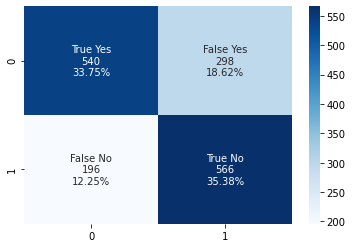

In [137]:
cf_matrix = confusion_matrix(ys4_test, predictions)
group_names = ['True Yes', 'False Yes', 
               'False No', 'True No']

group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

In [140]:
# ROC curves are for binary classification, so here is a "gambiarra" from stackoverflow :P
# AUC ROC measures the probabilities over the decision of the correct class,
## so for the other metrics a wrong prediction 0.2 --> 1.0 = 0.49 --> 1.0,
## while for AUC ROC 0.49 would be considered a smaller mistake

def plot_multiclass_roc(clf, Xs4_test, ys4_test, n_classes, figsize=(17, 6)):
    ys4_score = clf.decision_function(Xs4_test)

    # structures
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    # calculate dummies once
    ys4_test_dummies = pd.get_dummies(ys4_test, drop_first=False).values
    for i in range(n_classes):
        fpr[i], tpr[i], _ = metrics.roc_curve(ys4_test_dummies[:, i], ys4_score[:, i])
        roc_auc[i] = metrics.auc(fpr[i], tpr[i])

    # roc for each class
    fig, ax = plt.subplots(figsize=figsize)
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver operating characteristic example')
    for i in range(n_classes):
        ax.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f) for label %i' % (roc_auc[i], i))
    ax.legend(loc="best")
    ax.grid(alpha=.4)
    sns.despine()
    plt.show()

plot_multiclass_roc(classification, Xs4_test, ys4_test, n_classes=2, figsize=(16, 10))

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [141]:
#questions for Abhi:
#should we remove outliers in logistic regression ?
#my accuracy score when I don't sample up or down is 95% but when I sample it is around 70% --> because performs well on imbalanced ?
#can you help me with def plot_multiclass_roc ? i have an error